In [163]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata
import missingno as msno
import math 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
pd.set_option("display.max_columns", 30)

## Useful Functions

In [164]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "geekbrains-competitive-data-analysis"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data


def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
    """
    Hold-Out валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    split_params: List[float], optional, default = [0.7, 0.2, 0.1]
        Параметры (доли) разбиения выборки.
        Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].
    
    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimator: catboost.core.CatBoostClassifier
        Обученный классификатор catboost.

    test_prediction: np.array, optional
        Вектор прогнозов для тестовой выборки.
        Опциональный объект, возвращается только, если split_params
        содержит 3 значения.

    """
    numeric = list(set(x_train.columns) - set(categorical))
    x_train, x_valid = train_test_split(
        X, train_size=split_params[0], random_state=27
    )
    y_train, y_valid = train_test_split(
        y, train_size=split_params[0], random_state=27
    )

    if len(split_params) == 3:
        test_size = int(split_params[2] * X.shape[0])

        x_valid, x_test = train_test_split(
            x_valid, test_size=test_size, random_state=72
        )
        y_valid, y_test = train_test_split(
            y_valid, test_size=test_size, random_state=72
        )

    model = cb.CatBoostClassifier(**params)
    model.fit(
        x_train, y_train, categorical,
        eval_set=[(x_train, y_train), (x_valid, y_valid)]
    )

    print("="*80)
    valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    print(f"Valid Score = {round(valid_score, 4)}")

    if len(split_params) == 3:

        test_prediction = model.predict_proba(x_test)[:, 1]
        test_score = roc_auc_score(y_test, test_prediction)
        print(f"Test Score = {round(test_score, 4)}")

        return estimator, test_prediction

    else:
        return estimator

In [165]:
def create_age_cat(age):
    age = age / 365
    if age < 25:
        age_cat = 0
    elif age >= 25 and age < 45:
        age_cat = 1
    elif age >= 45 and age < 60:
        age_cat = 2
    elif age >= 60 and age < 67:
        age_cat = 3
    elif age >= 67:
        age_cat = 4
    return age_cat

In [166]:
def limit_age(age):
    if age > 36500:
        age = 36500
    return age

In [167]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()
    #обработка явных выбросов
    X["age"] = X["age"].apply(lambda x: limit_age(x))

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    
    X["Family_size_child"] = X["family_size"] - X["childrens"] #кол-во взрослых в семье

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]
    
    #Добавление новой категориальной переменной - возрастная категория
    X["age_cat"] = X["age"].apply(lambda x: create_age_cat(x))
    #вычислить доход на ребенка.
    X["ratio_salary_to_child"] = X["total_salary"] / X["childrens"]  
    X["ratio_salary_to_child"] = X["total_salary"] / X["family_size"]

    return X

In [168]:
from typing import List, Optional

def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [169]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
#    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        #-----
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
          params=params,
          dtrain=dtrain,
          evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
          early_stopping_rounds=25,
          num_boost_round=1000,
          verbose_eval=10,
          maximize=True,
        )
        #____
        
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


In [170]:
from tqdm import tqdm

def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    dvalid = xgb.DMatrix(x_valid, y_valid)
    scores = {}
    y_pred = estimator.predict(dvalid)#(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])
        dvalid = xgb.DMatrix(x_valid_copy, y_valid)
        y_pred = estimator.predict(dvalid)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

## Base Tables

In [171]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [172]:
train.head(2)

,application_number,target,name_contract_type
0,123687442,0,Cash
1,123597908,1,Cash


In [173]:
train['target'].value_counts()

0    101196
1      8897
Name: target, dtype: int64

In [174]:
train['application_number'].nunique()

110093

In [175]:
bki = get_input("bki.csv")
bki.head(2)

bki.csv: shape = 945234 rows, 17 cols


,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


Суть манипуляций: отфильтровать самую свежую информацию по нашему кредиту

In [176]:
bki['application_number'].nunique()

273131

In [177]:
bki[bki['days_credit_update'].isnull()]

,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity


In [178]:
bki[bki['bureau_id'].isnull()]

,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity


если bki есть дубли, то необходимо оставить только с минимальным days_credit_update

In [179]:
aggs = {
    "days_credit_update": ["min"],
}

stats = create_numerical_aggs(
    bki, groupby_id="application_number", aggs=aggs, suffix="_BY_APP"
)
stats.head(n=2)


,application_number,DAYS_CREDIT_UPDATE_MIN_BY_APP
0,123423340,6.0
1,123423341,7.0


In [180]:
stats = stats.rename(columns={
    "DAYS_CREDIT_UPDATE_MIN_BY_APP": "FRASHMENT"
})

bki = bki.rename(columns={
    "days_credit_update": "FRASHMENT"
})

In [181]:
bki = bki.merge(
    stats, on=["application_number", "FRASHMENT"]
)
bki.head(2)

,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,FRASHMENT,amt_annuity
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.0,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.0,0.000,0.0,0.0,Credit card,116.0,NaN


In [182]:
bki["credit_active_digital"] = 0
bki.loc[bki["credit_active"]=='Active', "credit_active_digital"] = 1

In [183]:
#убираем дубли
aggs = {
    "credit_active_digital": [np.mean],
    'amt_credit_max_overdue': ["min", "max", np.mean]    
}

stats2 = create_numerical_aggs(
    bki, groupby_id="application_number", aggs=aggs, prefix='BKI_', suffix="_BY_APP"
)
stats2.head(n=2)

,application_number,BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP
0,123423340,1.0,NaN,NaN,NaN
1,123423341,1.0,NaN,NaN,NaN


в stats2 учитываем только свежую информцию и убрали тухляк

In [184]:
data = data.merge(
    stats2, how="left", on="application_number"
)

In [185]:
data.head(2)

,application_number,target,name_contract_type,BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP
0,123687442,0.0,Cash,0.0,4714.425,4714.425,4714.425
1,123597908,1.0,Cash,1.0,NaN,NaN,NaN


In [186]:
#applications_history = get_input("applications_history.csv")
#applications_history.head(2)

In [187]:
#applications_history['Approved'] = 0
#applications_history['Refused'] = 1

#applications_history.loc[applications_history['name_contract_status'] == 'Approved', 'Approved'] = 1
#applications_history.loc[applications_history['name_contract_status'] == 'Approved', 'Refused'] = 0

In [188]:
#applications_history['amount_payment']= applications_history['amount_payment'].fillna(0)
#applications_history['prev_application_number'].nunique()

Сгруппировать по application_number и получить: 
count(prev_application_number), mean(amount_credit), sum(amount_payment)

In [189]:
#aggs = {
#    "prev_application_number": ["count"],
#    "Approved": [np.sum],
#    "Refused": [np.sum],
#    "cnt_payment": [np.mean]
#}

#stats = create_numerical_aggs(
#    applications_history, groupby_id="application_number", aggs=aggs, suffix="_BY_APP"
#)
#stats.head(n=2)


In [190]:
#stats = stats.rename(columns={
#    "PREV_APPLICATION_NUMBER_COUNT_BY_APP": "PREV_APPS_COUNT"
#})
#data = data.merge(
#    stats, how="left", on="application_number"
#)
#data["PREV_APPS_COUNT"] = data["PREV_APPS_COUNT"].fillna(0)

In [191]:
#data.head(n=2)

## client_profile

In [192]:
client_profile = get_input("client_profile.csv")

client_profile.csv: shape = 250000 rows, 24 cols


In [193]:
client_profile.describe()

,application_number,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,0.057072,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,0.231981,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,0.000000,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,0.000000,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,0.000000,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [194]:
7489 / 365

20.517808219178082

Анализ и заполнение пропусков

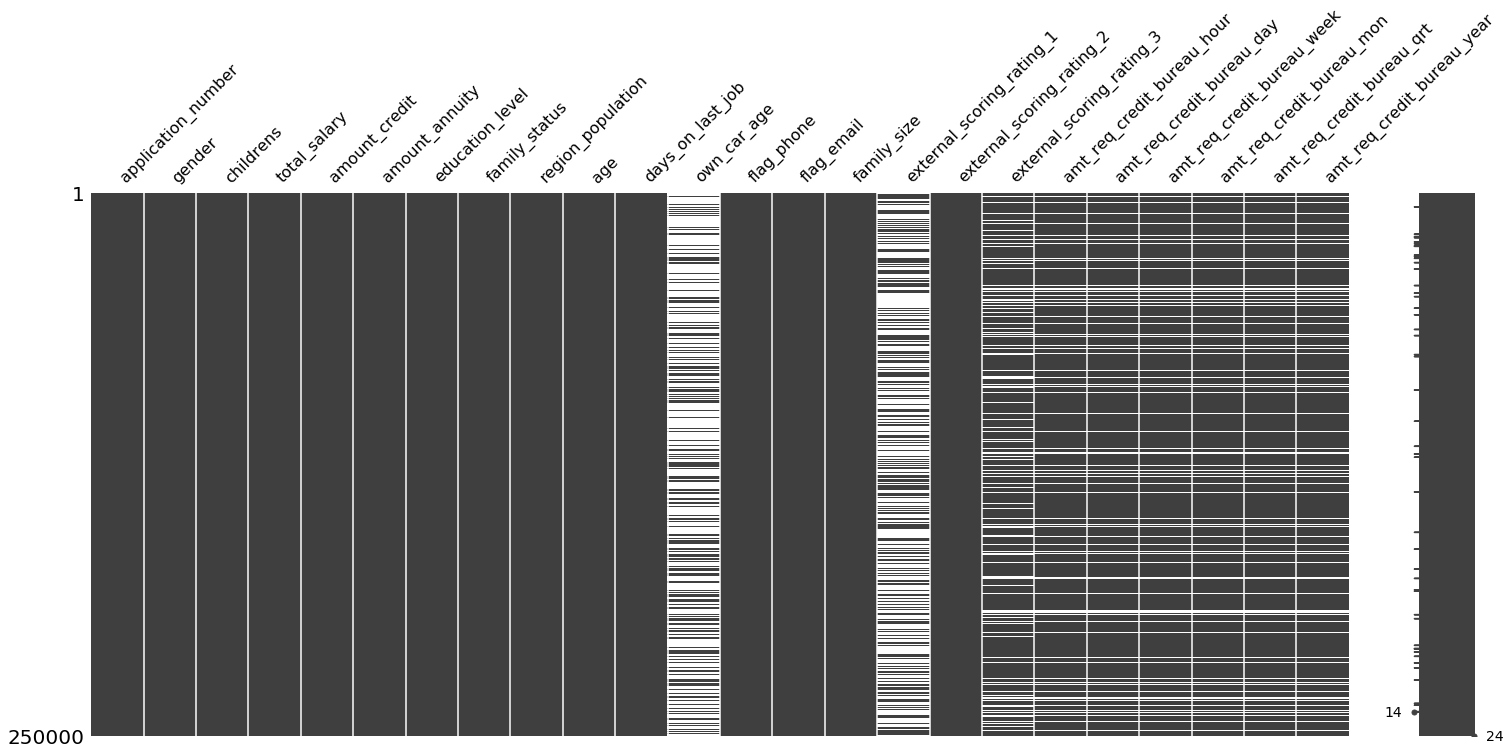

In [195]:
msno.matrix(client_profile)

In [196]:
client_profile.isnull().sum()

application_number                 0
gender                             0
childrens                          0
total_salary                       0
amount_credit                      0
amount_annuity                    11
education_level                    0
family_status                      0
region_population                  0
age                                0
days_on_last_job                   0
own_car_age                   164959
flag_phone                         0
flag_email                         0
family_size                        2
external_scoring_rating_1     140879
external_scoring_rating_2        532
external_scoring_rating_3      49538
amt_req_credit_bureau_hour     33707
amt_req_credit_bureau_day      33707
amt_req_credit_bureau_week     33707
amt_req_credit_bureau_mon      33707
amt_req_credit_bureau_qrt      33707
amt_req_credit_bureau_year     33707
dtype: int64

ЗАПОЛНЯЕМ ПРОПУСКИ!!!

In [197]:
client_profile.loc[client_profile['external_scoring_rating_1'].isnull(), 'external_scoring_rating_1'] = 0 # client_profile['external_scoring_rating_1'].mean()
client_profile.loc[client_profile['external_scoring_rating_2'].isnull(), 'external_scoring_rating_2'] = 0 #client_profile['external_scoring_rating_2'].mean()
client_profile.loc[client_profile['external_scoring_rating_3'].isnull(), 'external_scoring_rating_3'] = 0 #client_profile['external_scoring_rating_3'].mean()
client_profile.loc[client_profile['amount_annuity'].isnull(), 'amount_annuity'] = client_profile['amount_annuity'].median()

In [198]:
client_profile.isnull().sum()

application_number                 0
gender                             0
childrens                          0
total_salary                       0
amount_credit                      0
amount_annuity                     0
education_level                    0
family_status                      0
region_population                  0
age                                0
days_on_last_job                   0
own_car_age                   164959
flag_phone                         0
flag_email                         0
family_size                        2
external_scoring_rating_1          0
external_scoring_rating_2          0
external_scoring_rating_3          0
amt_req_credit_bureau_hour     33707
amt_req_credit_bureau_day      33707
amt_req_credit_bureau_week     33707
amt_req_credit_bureau_mon      33707
amt_req_credit_bureau_qrt      33707
amt_req_credit_bureau_year     33707
dtype: int64

In [199]:
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,...,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,age_cat,ratio_salary_to_child
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,...,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,0,78750.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,...,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,0.000000,237475.743779,431008.094056,0.000000,12590.802122,22851.755462,3,135000.0


In [200]:
data = data.merge(
    client_profile, how="left", on="application_number"
)

Обработка категориальных переменных

In [201]:
pd.get_dummies(data["name_contract_type"]).head()

,Cash,Credit Card
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [202]:
pd.get_dummies(data["gender"]).head()

,F,M,XNA
0,0,1,0
1,0,0,0
2,1,0,0
3,0,1,0
4,0,0,0


In [203]:
pd.get_dummies(data["education_level"]).head()

,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
0,0,0,0,0,1
1,0,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,0,0,0,0


In [204]:
pd.get_dummies(data["family_status"]).head()

,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
0,0,1,0,0,0,0
1,0,0,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,0,0,0


In [205]:
freq_encoder = data["education_level"].value_counts(normalize=True)
data["education_level_freq_enc"] = data["education_level"].map(freq_encoder)
data[["education_level", "education_level_freq_enc"]].head(2)

,education_level,education_level_freq_enc
0,Secondary / secondary special,0.710221
1,NaN,NaN


группировка по категориальным переменным и получение среднего для основых характеристик

Задание 2: сгруппировать данные по age_cat, gender, education_level, famaly_status и посчитать среднюю total_salary, amount_credit, days_on_last_job. Добавить в качестве признака в набор данных. Посчитать разницу между характеристикой пользователя и средней по данному типу группировки. Построить отношение этих признаков.

In [206]:
data.head(2)

,application_number,target,name_contract_type,BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,...,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,age_cat,ratio_salary_to_child,education_level_freq_enc
0,123687442,0.0,Cash,0.0,4714.425,4714.425,4714.425,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,1.0,52500.0,0.710221
1,123597908,1.0,Cash,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
aggs = {
    "total_salary": [np.mean],
    "amount_credit": [np.mean],
    "days_on_last_job": [np.mean],
    "external_scoring_rating_1": [np.mean],
    "external_scoring_rating_2": [np.mean],
    "external_scoring_rating_3": [np.mean],
}

stats_1 = create_numerical_aggs(
    data, groupby_id="age_cat", aggs=aggs, suffix="_BY_AGE"
)

stats_2 = create_numerical_aggs(
    data, groupby_id="gender", aggs=aggs, suffix="_BY_GENDER"
)

stats_3 = create_numerical_aggs(
    data, groupby_id="education_level", aggs=aggs, suffix="_BY_EDUCATION"
)

stats_4 = create_numerical_aggs(
    data, groupby_id="family_status", aggs=aggs, suffix="_BY_FAMILY"
)

stats_1.head(n=2)

,age_cat,TOTAL_SALARY_MEAN_BY_AGE,AMOUNT_CREDIT_MEAN_BY_AGE,DAYS_ON_LAST_JOB_MEAN_BY_AGE,EXTERNAL_SCORING_RATING_1_MEAN_BY_AGE,EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE,EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE
0,0.0,145598.422818,415548.917827,778.265721,0.157518,0.417902,0.243111
1,1.0,176927.987631,593681.600854,2016.744551,0.242480,0.507483,0.394643


In [208]:
data = data.merge(
    stats_1, how="left", on="age_cat"
)

data = data.merge(
    stats_2, how="left", on="gender"
)

data = data.merge(
    stats_3, how="left", on="education_level"
)

data = data.merge(
    stats_4, how="left", on="family_status"
)

data.head(n=2)

,application_number,target,name_contract_type,BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,...,EXTERNAL_SCORING_RATING_1_MEAN_BY_GENDER,EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION,DAYS_ON_LAST_JOB_MEAN_BY_EDUCATION,EXTERNAL_SCORING_RATING_1_MEAN_BY_EDUCATION,EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION,EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION,TOTAL_SALARY_MEAN_BY_FAMILY,AMOUNT_CREDIT_MEAN_BY_FAMILY,DAYS_ON_LAST_JOB_MEAN_BY_FAMILY,EXTERNAL_SCORING_RATING_1_MEAN_BY_FAMILY,EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY
0,123687442,0.0,Cash,0.0,4714.425,4714.425,4714.425,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,0.165165,0.509473,0.39678,155385.898168,571503.509551,2430.660016,0.192264,0.499778,0.409442,171239.152681,643091.415473,2502.156595,0.224993,0.518844,0.419205
1,123597908,1.0,Cash,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
data["total_salary_TO_TOTAL_SALARY_MEAN_BY_AGE"] = data["total_salary"] / data["TOTAL_SALARY_MEAN_BY_AGE"]
data["DELTA_total_salary_TO_TOTAL_SALARY_MEAN_BY_AGE"] = data["total_salary"] - data["TOTAL_SALARY_MEAN_BY_AGE"]

data["total_salary_TO_TOTAL_SALARY_MEAN_BY_GENDER"] = data["total_salary"] / data["TOTAL_SALARY_MEAN_BY_GENDER"]
data["DELTA_total_salary_TO_TOTAL_SALARY_MEAN_BY_GENDER"] = data["total_salary"] - data["TOTAL_SALARY_MEAN_BY_GENDER"]

data["total_salary_TO_TOTAL_SALARY_MEAN_BY_EDUCATION"] = data["total_salary"] / data["TOTAL_SALARY_MEAN_BY_EDUCATION"]
data["DELTA_total_salary_TO_TOTAL_SALARY_MEAN_BY_EDUCATION"] = data["total_salary"] - data["TOTAL_SALARY_MEAN_BY_EDUCATION"]

data["total_salary_TO_TOTAL_SALARY_MEAN_BY_FAMILY"] = data["total_salary"] / data["TOTAL_SALARY_MEAN_BY_FAMILY"]
data["DELTA_total_salary_TO_TOTAL_SALARY_MEAN_BY_FAMILY"] = data["total_salary"] - data["TOTAL_SALARY_MEAN_BY_FAMILY"]

#------------------------------

data["amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_AGE"] = data["amount_credit"] / data["AMOUNT_CREDIT_MEAN_BY_AGE"]
data["DELTA_amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_AGE"] = data["amount_credit"] - data["AMOUNT_CREDIT_MEAN_BY_AGE"]

data["amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_GENDER"] = data["amount_credit"] / data["AMOUNT_CREDIT_MEAN_BY_GENDER"]
data["DELTA_amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_GENDER"] = data["amount_credit"] - data["AMOUNT_CREDIT_MEAN_BY_GENDER"]

data["amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_EDUCATION"] = data["amount_credit"] / data["AMOUNT_CREDIT_MEAN_BY_EDUCATION"]
data["DELTA_amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_EDUCATION"] = data["amount_credit"] - data["AMOUNT_CREDIT_MEAN_BY_EDUCATION"]

data["amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_FAMILY"] = data["amount_credit"] / data["AMOUNT_CREDIT_MEAN_BY_FAMILY"]
data["DELTA_amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_FAMILY"] = data["amount_credit"] - data["AMOUNT_CREDIT_MEAN_BY_FAMILY"]

#---------------------------------

data["days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_AGE"] = data["days_on_last_job"] / data["DAYS_ON_LAST_JOB_MEAN_BY_AGE"]
data["DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_AGE"] = data["days_on_last_job"] - data["DAYS_ON_LAST_JOB_MEAN_BY_AGE"]

data["days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_GENDER"] = data["days_on_last_job"] / data["DAYS_ON_LAST_JOB_MEAN_BY_GENDER"]
data["DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_GENDER"] = data["days_on_last_job"] - data["DAYS_ON_LAST_JOB_MEAN_BY_GENDER"]

data["days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_EDUCATION"] = data["days_on_last_job"] / data["DAYS_ON_LAST_JOB_MEAN_BY_EDUCATION"]
data["DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_EDUCATION"] = data["days_on_last_job"] - data["DAYS_ON_LAST_JOB_MEAN_BY_EDUCATION"]

data["days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_FAMILY"] = data["days_on_last_job"] / data["DAYS_ON_LAST_JOB_MEAN_BY_FAMILY"]
data["DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_FAMILY"] = data["days_on_last_job"] - data["DAYS_ON_LAST_JOB_MEAN_BY_FAMILY"]

#-------------------------------------

data["external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_AGE"] = data["external_scoring_rating_1"] / data["EXTERNAL_SCORING_RATING_1_MEAN_BY_AGE"]
data["DELTA_external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_AGE"] = data["external_scoring_rating_1"] - data["EXTERNAL_SCORING_RATING_1_MEAN_BY_AGE"]

data["external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_GENDER"] = data["external_scoring_rating_1"] / data["EXTERNAL_SCORING_RATING_1_MEAN_BY_GENDER"]
data["DELTA_external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_GENDER"] = data["external_scoring_rating_1"] - data["EXTERNAL_SCORING_RATING_1_MEAN_BY_GENDER"]

data["external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_EDUCATION"] = data["external_scoring_rating_1"] / data["EXTERNAL_SCORING_RATING_1_MEAN_BY_EDUCATION"]
data["DELTA_external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_EDUCATION"] = data["external_scoring_rating_1"] - data["EXTERNAL_SCORING_RATING_1_MEAN_BY_EDUCATION"]

data["external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_FAMILY"] = data["external_scoring_rating_1"] / data["EXTERNAL_SCORING_RATING_1_MEAN_BY_FAMILY"]
data["DELTA_external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_FAMILY"] = data["external_scoring_rating_1"] - data["EXTERNAL_SCORING_RATING_1_MEAN_BY_FAMILY"]

#------------------------------

data["external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE"] = data["external_scoring_rating_2"] / data["EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE"]
data["DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE"] = data["external_scoring_rating_2"] - data["EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE"]

data["external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER"] = data["external_scoring_rating_2"] / data["EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER"]
data["DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER"] = data["external_scoring_rating_2"] - data["EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER"]

data["external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION"] = data["external_scoring_rating_2"] / data["EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION"]
data["DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION"] = data["external_scoring_rating_2"] - data["EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION"]

data["external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY"] = data["external_scoring_rating_2"] / data["EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY"]
data["DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY"] = data["external_scoring_rating_2"] - data["EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY"]

#------------------------------

data["external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE"] = data["external_scoring_rating_3"] / data["EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE"]
data["DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE"] = data["external_scoring_rating_3"] - data["EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE"]

data["external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER"] = data["external_scoring_rating_3"] / data["EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER"]
data["DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER"] = data["external_scoring_rating_3"] - data["EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER"]

data["external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION"] = data["external_scoring_rating_3"] / data["EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION"]
data["DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION"] = data["external_scoring_rating_3"] - data["EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION"]

data["external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY"] = data["external_scoring_rating_3"] / data["EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY"]
data["DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY"] = data["external_scoring_rating_3"] - data["EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY"]

#------------------------------

#data['not_client_profile'] = data['amount_credit'].isnull()

data.head(n=3)

,application_number,target,name_contract_type,BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,...,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE,external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION,external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY
0,123687442,0.0,Cash,0.0,4714.425,4714.425,4714.425,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,0.138431,1.267807,0.136441,1.292402,0.146136,1.244909,0.127070,1.815743,0.321927,1.805963,0.319790,1.750113,0.307128,1.709357,0.297366
1,123597908,1.0,Cash,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0.0,Cash,1.0,NaN,NaN,NaN,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,...,0.149273,1.325494,0.167512,1.229111,0.127155,1.314748,0.163305,0.617272,-0.166087,0.644260,-0.147909,0.641612,-0.149625,0.638993,-0.151336


Построим матрицу корелляций

In [210]:
mask = data["target"].isnull()
train, test = data.loc[~mask], data.loc[mask]
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 130


Index(['application_number', 'target', 'BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP',
       'BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP',
       'BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP',
       'BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP', 'childrens', 'total_salary',
       'amount_credit', 'amount_annuity',
       ...
       'external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY',
       'DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY',
       'external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE',
       'DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE',
       'external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER',
       'DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER',
       'external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION',
       'DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION',
       'external_scoring_rati

In [211]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target                                                                         1.000000
ratio_car_to_age                                                               0.054001
TOTAL_SALARY_MEAN_BY_GENDER                                                    0.051448
AMOUNT_CREDIT_MEAN_BY_GENDER                                                   0.051376
education_level_freq_enc                                                       0.045909
                                                                                 ...   
DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER   -0.157712
external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER         -0.157860
external_scoring_rating_2                                                     -0.158356
external_scoring_rating_mean                                                  -0.173897
external_scoring_rating_max                                                   -0.196829
Name: target, Length: 130, dtype

In [212]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = True)
df = pd.DataFrame(corr_with_target[:30])
df

,target
external_scoring_rating_max,-0.196829
external_scoring_rating_mean,-0.173897
external_scoring_rating_2,-0.158356
external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,-0.157860
DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,-0.157712
external_scoring_weighted,-0.157188
external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,-0.157184
external_scoring_rating_nanmedian,-0.157043
DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,-0.156990
external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE,-0.154316


In [213]:
features_list = ['target']
for index, row in df.iterrows():
    features_list.append(index)
features_list    

['target',
 'external_scoring_rating_max',
 'external_scoring_rating_mean',
 'external_scoring_rating_2',
 'external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER',
 'DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER',
 'external_scoring_weighted',
 'external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY',
 'external_scoring_rating_nanmedian',
 'DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY',
 'external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE',
 'DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE',
 'external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION',
 'DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION',
 'external_scoring_rating_3',
 'external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION',
 'DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION',
 'external_scoring_r

Correlation Heat Map
Тепловая карта - лучший способ быстро получить информацию о силе связи между переменными.

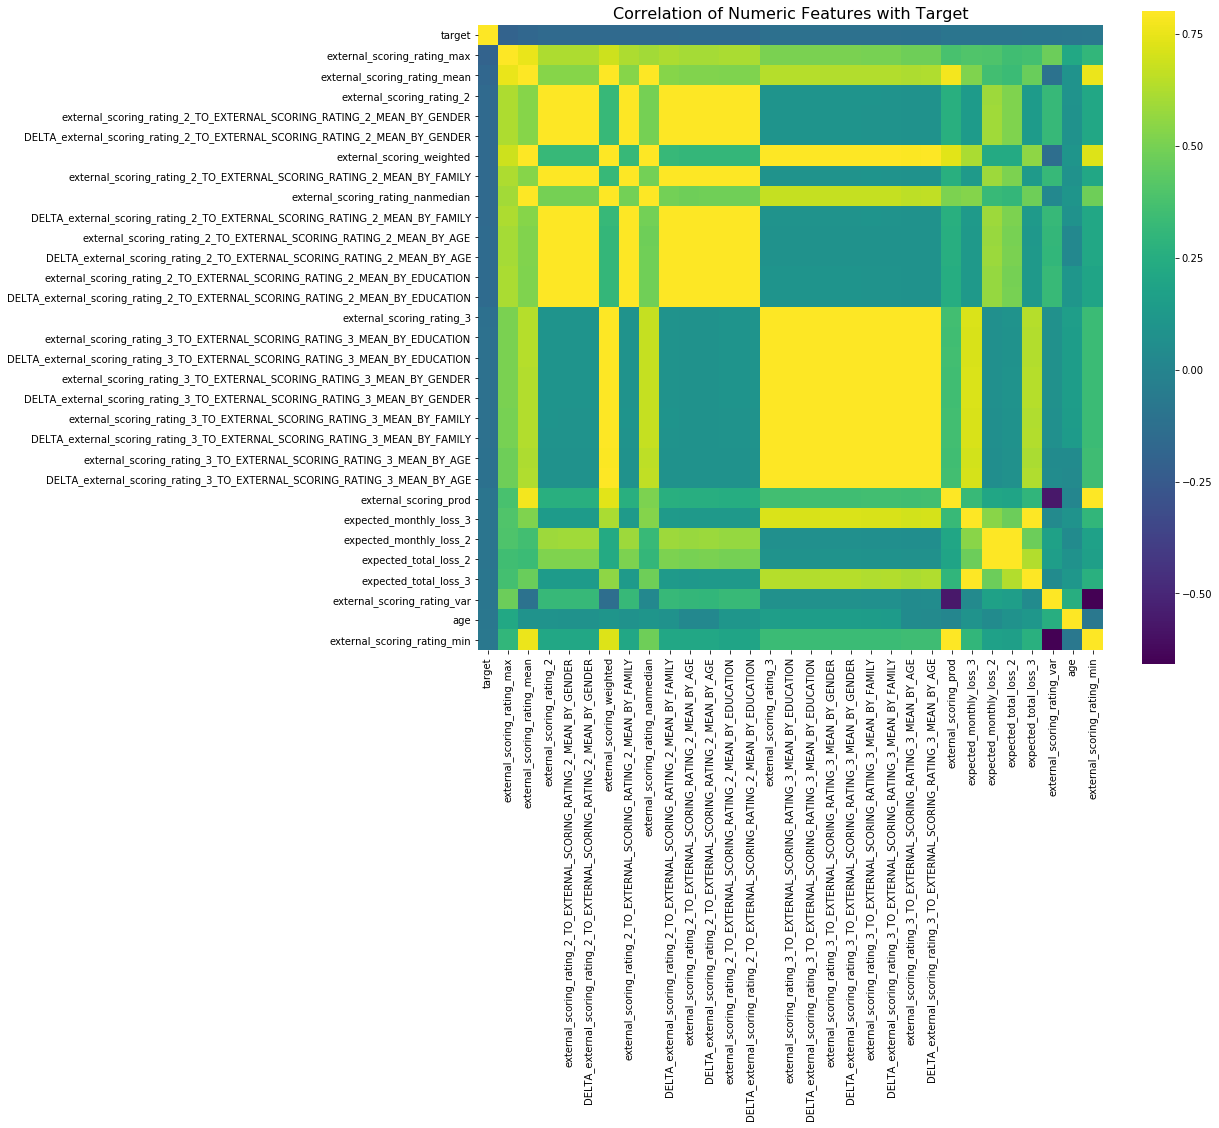

In [214]:
correlation = train[features_list].corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

## baseline

In [215]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target", "name_contract_type", "gender", "education_level", "family_status"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

XGBoost

In [216]:
new_train = train[numerical]


x_train, x_valid = train_test_split(
    new_train, train_size=0.7, random_state=27
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 77065 rows, 128 cols
x_valid.shape = 33028 rows, 128 cols


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [217]:
data.head(2)

,application_number,target,name_contract_type,BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,...,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE,external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_GENDER,external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_EDUCATION,external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_EDUCATION,external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY,DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY
0,123687442,0.0,Cash,0.0,4714.425,4714.425,4714.425,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,0.138431,1.267807,0.136441,1.292402,0.146136,1.244909,0.12707,1.815743,0.321927,1.805963,0.31979,1.750113,0.307128,1.709357,0.297366
1,123597908,1.0,Cash,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
data.columns[:30]

Index(['application_number', 'target', 'name_contract_type',
       'BKI_CREDIT_ACTIVE_DIGITAL_MEAN_BY_APP',
       'BKI_AMT_CREDIT_MAX_OVERDUE_MIN_BY_APP',
       'BKI_AMT_CREDIT_MAX_OVERDUE_MAX_BY_APP',
       'BKI_AMT_CREDIT_MAX_OVERDUE_MEAN_BY_APP', 'gender', 'childrens',
       'total_salary', 'amount_credit', 'amount_annuity', 'education_level',
       'family_status', 'region_population', 'age', 'days_on_last_job',
       'own_car_age', 'flag_phone', 'flag_email', 'family_size',
       'external_scoring_rating_1', 'external_scoring_rating_2',
       'external_scoring_rating_3', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object')

In [219]:
%%time

params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(
    x_train, y_train
)
dvalid = xgb.DMatrix(
    x_valid, y_valid
)

model = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=1000,
    verbose_eval=10,
    maximize=True,
)

[0]	dtrain-auc:0.69480	dvalid-auc:0.68438
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.70773	dvalid-auc:0.69572
[20]	dtrain-auc:0.71117	dvalid-auc:0.69823
[30]	dtrain-auc:0.71293	dvalid-auc:0.70008
[40]	dtrain-auc:0.71581	dvalid-auc:0.70192
[50]	dtrain-auc:0.71911	dvalid-auc:0.70351
[60]	dtrain-auc:0.72168	dvalid-auc:0.70518
[70]	dtrain-auc:0.72398	dvalid-auc:0.70567
[80]	dtrain-auc:0.72603	dvalid-auc:0.70582
[90]	dtrain-auc:0.72796	dvalid-auc:0.70631
[100]	dtrain-auc:0.72945	dvalid-auc:0.70659
[110]	dtrain-auc:0.73183	dvalid-auc:0.70831
[120]	dtrain-auc:0.73447	dvalid-auc:0.71025
[130]	dtrain-auc:0.73620	dvalid-auc:0.71160
[140]	dtrain-auc:0.73802	dvalid-auc:0.71230
[150]	dtrain-auc:0.73929	dvalid-auc:0.71273
[160]	dtrain-auc:0.74061	dvalid-auc:0.71331
[170]	dtrain-auc:0.74209	dvalid-auc:0.71382
[180]	dtrain-auc:0.74388	dvalid-auc:0.71456
[190]	dtrain-auc:0.74496	dvali

In [225]:
oof_preds_xgb = roc_auc_score(y_valid, model.predict(dvalid))
oof_preds_xgb

0.7317027857034248

In [224]:
#подсчет важности каждого признака
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=x_valid, y_valid=y_valid#target
)

100%|████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


In [226]:
perm_importance

external_scoring_rating_nanmedian                                           0.021069
ratio_credit_to_annuity                                                     0.018638
external_scoring_rating_max                                                 0.017617
external_scoring_rating_var                                                 0.005974
TOTAL_SALARY_MEAN_BY_EDUCATION                                              0.004679
                                                                              ...   
ratio_credit_to_age                                                        -0.000469
amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_AGE                                 -0.000477
DELTA_amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_GENDER                        -0.000480
external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE         -0.000562
DELTA_external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_AGE   -0.000578
Length: 128, dtype: float64

In [227]:
df = pd.DataFrame(perm_importance)
df[df[0]<0]

,0
flag_email,-2.817355e-07
EXTERNAL_SCORING_RATING_2_MEAN_BY_FAMILY,-9.799494e-07
flag_phone,-6.069562e-06
days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_GENDER,-7.006638e-06
amt_req_credit_bureau_day,-7.263875e-06
AMOUNT_CREDIT_MEAN_BY_EDUCATION,-1.050996e-05
DELTA_external_scoring_rating_2_TO_EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE,-1.474211e-05
childrens,-2.228772e-05
external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_GENDER,-3.535168e-05
total_salary,-3.696859e-05


In [228]:
df = pd.DataFrame(perm_importance)
df = df[df[0]>0]
df

,0
external_scoring_rating_nanmedian,0.021069
ratio_credit_to_annuity,0.018638
external_scoring_rating_max,0.017617
external_scoring_rating_var,0.005974
TOTAL_SALARY_MEAN_BY_EDUCATION,0.004679
...,...
Family_size_child,0.000005
ratio_car_to_age,0.000005
total_salary_TO_TOTAL_SALARY_MEAN_BY_FAMILY,0.000003
EXTERNAL_SCORING_RATING_2_MEAN_BY_AGE,0.000002


In [229]:
good_features = list(df.index)
good_features

['external_scoring_rating_nanmedian',
 'ratio_credit_to_annuity',
 'external_scoring_rating_max',
 'external_scoring_rating_var',
 'TOTAL_SALARY_MEAN_BY_EDUCATION',
 'external_scoring_prod',
 'expected_total_loss_3',
 'age',
 'ratio_annuity_to_salary',
 'external_scoring_weighted',
 'external_scoring_rating_min',
 'DELTA_external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE',
 'external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_AGE',
 'ratio_annuity_to_experience',
 'external_scoring_rating_mean',
 'DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_AGE',
 'DELTA_external_scoring_rating_1_TO_EXTERNAL_SCORING_RATING_1_MEAN_BY_GENDER',
 'external_scoring_rating_3_TO_EXTERNAL_SCORING_RATING_3_MEAN_BY_FAMILY',
 'DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_EDUCATION',
 'DELTA_amount_credit_TO_AMOUNT_CREDIT_MEAN_BY_EDUCATION',
 'ratio_salary_to_child',
 'days_on_last_job',
 'DELTA_days_on_last_job_TO_DAYS_ON_LAST_JOB_MEAN_BY_FAMILY',
 'DELTA_external_scoring_r

Модель только с хорошими фичами

In [230]:
new_train = train[good_features]


x_train, x_valid = train_test_split(
    new_train, train_size=0.7, random_state=27
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 77065 rows, 77 cols
x_valid.shape = 33028 rows, 77 cols


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [231]:
%%time

params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(
    x_train, y_train
)
dvalid = xgb.DMatrix(
    x_valid, y_valid
)

model = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=1000,
    verbose_eval=10,
    maximize=True,
)

[0]	dtrain-auc:0.69433	dvalid-auc:0.68254
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.70925	dvalid-auc:0.69727
[20]	dtrain-auc:0.71295	dvalid-auc:0.69953
[30]	dtrain-auc:0.71498	dvalid-auc:0.70003
[40]	dtrain-auc:0.71712	dvalid-auc:0.70031
[50]	dtrain-auc:0.72034	dvalid-auc:0.70238
[60]	dtrain-auc:0.72224	dvalid-auc:0.70350
[70]	dtrain-auc:0.72422	dvalid-auc:0.70480
[80]	dtrain-auc:0.72677	dvalid-auc:0.70535
[90]	dtrain-auc:0.72830	dvalid-auc:0.70526
[100]	dtrain-auc:0.72968	dvalid-auc:0.70549
[110]	dtrain-auc:0.73165	dvalid-auc:0.70724
[120]	dtrain-auc:0.73384	dvalid-auc:0.70875
[130]	dtrain-auc:0.73553	dvalid-auc:0.71044
[140]	dtrain-auc:0.73688	dvalid-auc:0.71134
[150]	dtrain-auc:0.73815	dvalid-auc:0.71239
[160]	dtrain-auc:0.73985	dvalid-auc:0.71293
[170]	dtrain-auc:0.74145	dvalid-auc:0.71413
[180]	dtrain-auc:0.74254	dvalid-auc:0.71485
[190]	dtrain-auc:0.74450	dvali

In [232]:
oof_preds_xgb = roc_auc_score(y_valid, model.predict(dvalid))
oof_preds_xgb

0.7156790264868934

Оптимизация гиперпараметров

In [240]:
def xgboost_optimize_params(max_depth, min_child_weights, colsample_bytree):

    params["max_depth"] = int(max_depth)
    params["min_child_weights"] = int(min_child_weights)
    params["colsample_bytree"] = colsample_bytree

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=25,
        num_boost_round=1000,
        verbose_eval=10,
        maximize=True,
    )

    return roc_auc_score(y_valid, model.predict(dvalid))

In [241]:
params_search = {
    "max_depth": (3, 15),
    "min_child_weights": (5, 500),
    "colsample_bytree": (0.3, 0.9)
}

xgb_params_search = BayesianOptimization(
    xgboost_optimize_params,
    pbounds=params_search,
    random_state=27
)
xgb_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)

|   iter    |  target   | colsam... | max_depth | min_ch... |
-------------------------------------------------------------
[14:19:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	dtrain-auc:0.72664	dvalid-auc:0.68118
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.78290	dvalid-auc:0.70147
[20]	dtrain-auc:0.80129	dvalid-auc:0.70699
[30]	dtrain-auc:0.81131	dvalid-auc:0.70815
[40]	dtrain-auc:0.81946	dvalid-auc:0.70884
[50]	dtrain-auc:0.82528	dvalid-auc:0.70915
[60]	dtrain-auc:0.83317	dvalid-auc:0.70965
[70]	dtrain-auc:0.84171	dvalid-auc:0

Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.70744	dvalid-auc:0.70047
[20]	dtrain-auc:0.70795	dvalid-auc:0.70140
[30]	dtrain-auc:0.70983	dvalid-auc:0.70323
[40]	dtrain-auc:0.71039	dvalid-auc:0.70312
[50]	dtrain-auc:0.71163	dvalid-auc:0.70408
[60]	dtrain-auc:0.71249	dvalid-auc:0.70508
[70]	dtrain-auc:0.71291	dvalid-auc:0.70561
[80]	dtrain-auc:0.71452	dvalid-auc:0.70711
[90]	dtrain-auc:0.71578	dvalid-auc:0.70796
[100]	dtrain-auc:0.71648	dvalid-auc:0.70859
[110]	dtrain-auc:0.71754	dvalid-auc:0.70962
[120]	dtrain-auc:0.71935	dvalid-auc:0.71130
[130]	dtrain-auc:0.72087	dvalid-auc:0.71232
[140]	dtrain-auc:0.72193	dvalid-auc:0.71236
[150]	dtrain-auc:0.72312	dvalid-auc:0.71316
[160]	dtrain-auc:0.72394	dvalid-auc:0.71399
[170]	dtrain-auc:0.72485	dvalid-auc:0.71377
[180]	dtrain-auc:0.72603	dvalid-auc:0.71443
[190]	dtrain-auc:0.72718	dvalid-auc:0.71483
[200]	dtrain-auc:0.72770	dva

Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.70470	dvalid-auc:0.69761
[20]	dtrain-auc:0.70607	dvalid-auc:0.69892
[30]	dtrain-auc:0.70883	dvalid-auc:0.70206
[40]	dtrain-auc:0.70901	dvalid-auc:0.70210
[50]	dtrain-auc:0.71095	dvalid-auc:0.70419
[60]	dtrain-auc:0.71226	dvalid-auc:0.70490
[70]	dtrain-auc:0.71311	dvalid-auc:0.70506
[80]	dtrain-auc:0.71435	dvalid-auc:0.70622
[90]	dtrain-auc:0.71583	dvalid-auc:0.70731
[100]	dtrain-auc:0.71650	dvalid-auc:0.70836
[110]	dtrain-auc:0.71722	dvalid-auc:0.70952
[120]	dtrain-auc:0.71901	dvalid-auc:0.71113
[130]	dtrain-auc:0.72016	dvalid-auc:0.71280
[140]	dtrain-auc:0.72155	dvalid-auc:0.71276
[150]	dtrain-auc:0.72239	dvalid-auc:0.71282
[160]	dtrain-auc:0.72348	dvalid-auc:0.71371
[170]	dtrain-auc:0.72420	dvalid-auc:0.71351
[180]	dtrain-auc:0.72527	dvalid-auc:0.71397
[190]	dtrain-auc:0.72630	dvalid-auc:0.71410
[200]	dtrain-auc:0.72720	dva

[0]	dtrain-auc:0.73951	dvalid-auc:0.66666
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.80146	dvalid-auc:0.70010
[20]	dtrain-auc:0.81580	dvalid-auc:0.69932
[30]	dtrain-auc:0.82645	dvalid-auc:0.69945
[40]	dtrain-auc:0.83626	dvalid-auc:0.70035
Stopping. Best iteration:
[15]	dtrain-auc:0.80947	dvalid-auc:0.70083

|  8        |  0.7003   |  0.8551   |  14.98    |  157.6    |


In [242]:
optimal_xgb_params = xgb_params_search.max
optimal_xgb_params

{'target': 0.7325185384686554,
 'params': {'colsample_bytree': 0.8208019199278416,
  'max_depth': 7.600569274471442,
  'min_child_weights': 489.8310329115377}}

In [243]:
%%time

params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27,
    "colsample_bytree": 0.8,
    'max_depth': 8
}

dtrain = xgb.DMatrix(
    x_train, y_train
)
dvalid = xgb.DMatrix(
    x_valid, y_valid
)

model_opt = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=1000,
    verbose_eval=10,
    maximize=True,
)

[0]	dtrain-auc:0.70054	dvalid-auc:0.68720
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.73723	dvalid-auc:0.70427
[20]	dtrain-auc:0.74682	dvalid-auc:0.70615
[30]	dtrain-auc:0.74971	dvalid-auc:0.70756
[40]	dtrain-auc:0.75328	dvalid-auc:0.70838
[50]	dtrain-auc:0.75584	dvalid-auc:0.70819
[60]	dtrain-auc:0.75953	dvalid-auc:0.70870
[70]	dtrain-auc:0.76165	dvalid-auc:0.70899
[80]	dtrain-auc:0.76513	dvalid-auc:0.71012
[90]	dtrain-auc:0.76933	dvalid-auc:0.71076
[100]	dtrain-auc:0.77373	dvalid-auc:0.71128
[110]	dtrain-auc:0.77765	dvalid-auc:0.71244
[120]	dtrain-auc:0.78183	dvalid-auc:0.71402
[130]	dtrain-auc:0.78603	dvalid-auc:0.71503
[140]	dtrain-auc:0.78897	dvalid-auc:0.71587
[150]	dtrain-auc:0.79191	dvalid-auc:0.71663
[160]	dtrain-auc:0.79444	dvalid-auc:0.71724
[170]	dtrain-auc:0.79782	dvalid-auc:0.71799
[180]	dtrain-auc:0.80088	dvalid-auc:0.71830
[190]	dtrain-auc:0.80424	dvali

In [244]:
oof_preds_xgb = roc_auc_score(y_valid, model_opt.predict(dvalid))
oof_preds_xgb

0.7308420165119762

Подсчет итоговых результатов XGBoost

In [245]:
y_pred_xgb = np.zeros(test.shape[0])
test[good_features] = test[good_features].astype(float)
#test[categorial] = test[categorial].astype(str)

new_test = test[good_features]
dtest = xgb.DMatrix(new_test)

y_pred_xgb += model_opt.predict(dtest)

In [246]:
y_pred_xgb

array([0.04629891, 0.26316798, 0.19827591, ..., 0.08201464, 0.01851942,
       0.04828704])

In [247]:
y_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb
})
y_pred.to_csv("./geekbrains-competitive-data-analysis/ver_good_f_opt.csv",index=False)